<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ввод-параметров-поиска" data-toc-modified-id="Ввод-параметров-поиска-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ввод параметров поиска</a></span></li><li><span><a href="#Смотрим-таблицу-и--общее-количество-вакансий" data-toc-modified-id="Смотрим-таблицу-и--общее-количество-вакансий-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Смотрим таблицу и  общее количество вакансий</a></span></li><li><span><a href="#Информация-о-ЗП" data-toc-modified-id="Информация-о-ЗП-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Информация о ЗП</a></span></li><li><span><a href="#Топ-10-работодателей-по-количеству-опубликованных-вакансий" data-toc-modified-id="Топ-10-работодателей-по-количеству-опубликованных-вакансий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Топ-10 работодателей по количеству опубликованных вакансий</a></span></li><li><span><a href="#Профессии" data-toc-modified-id="Профессии-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Профессии</a></span></li><li><span><a href="#Топ-10-навыков" data-toc-modified-id="Топ-10-навыков-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Топ-10 навыков</a></span></li></ul></div>

In [2]:
import requests
import pandas as pd
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import os
import datetime
from PIL import Image
import numpy as np

In [3]:
todays_date = str(datetime.date.today())

In [4]:
# Получить название специализаций

spec = requests.get('https://api.hh.ru/specializations')
spec.json()

[{'id': '1',
  'name': 'Информационные технологии, интернет, телеком',
  'specializations': [{'id': '1.395',
    'name': 'Банковское ПО',
    'laboring': False},
   {'id': '1.400', 'name': 'Оптимизация сайта (SEO)', 'laboring': False},
   {'id': '1.420', 'name': 'Администратор баз данных', 'laboring': False},
   {'id': '1.474', 'name': 'Стартапы', 'laboring': False},
   {'id': '1.475', 'name': 'Игровое ПО', 'laboring': False},
   {'id': '1.536', 'name': 'CRM системы', 'laboring': False},
   {'id': '1.744', 'name': 'Другое', 'laboring': False},
   {'id': '1.3', 'name': 'CTO, CIO, Директор по IT', 'laboring': False},
   {'id': '1.9', 'name': 'Web инженер', 'laboring': False},
   {'id': '1.10', 'name': 'Web мастер', 'laboring': False},
   {'id': '1.25', 'name': 'Аналитик', 'laboring': False},
   {'id': '1.30', 'name': 'Арт-директор', 'laboring': False},
   {'id': '1.50',
    'name': 'Системы управления предприятием (ERP)',
    'laboring': False},
   {'id': '1.82', 'name': 'Инженер', 'labo

## Ввод параметров поиска

In [5]:
# Название вакансии
vacancy_name = 'Управление качеством'

In [6]:
def get_id_vacancies(vacancies):
    vacancies_id_list = []
    for page in range(19):
        
        # Параметры поиска
        #param = {'per_page': 100, 'page': page, 'area': 2, 'specialization':'18.208'} # Поиск по специализации
        #param = {'per_page': 100, 'page': page, 'area': 2, 'text':'"Экологическая безопасность"', "professional_role": ['79', '48', '49', '44', '10', '12', '25', '24', '34', '36', '73', '96', '104', '107', '112', '113', '114', '116', '121', '124', '125', '126']} #Поиск по слову
        param = {'per_page': 100, 'page': page, 'area': 2, 'text':'"Управление качеством"'} # Поиск по слову
        vacancies_id = requests.get('https://api.hh.ru/vacancies', params=param)
        vacancies_id = vacancies_id.json()['items']
        
        if not len(vacancies_id):
            break
        for v in vacancies_id:
            vacancies_id_list.append(v['id'])
    return vacancies_id_list

In [7]:
vacancies_id_list = get_id_vacancies(vacancy_name)

In [8]:
def get_dict_vacancies(vacancies_id_list):
    count = 0
    max_count = len(vacancies_id_list)
    f = IntProgress(min=0, max=max_count)
    display(f)
    data = {'id': [], 'name': [], 'city': [], 'salary_min': [], 'salary_max': [], 'salary_currency': [],
            'metro': [], 'experience': [],'skills': [], 'specializations': [],'professional_roles':[], 'employer': [], 'published_at': []}
    for vacancies_id in vacancies_id_list:
        vacancies = requests.get(f'https://api.hh.ru/vacancies/{vacancies_id}').json()
        data['id'].append(vacancies['id'])
        data['name'].append(vacancies['name'])
        data['city'].append(vacancies['area']['name'])
        if vacancies['salary'] is None:
            data['salary_min'].append(None)
            data['salary_max'].append(None)
            data['salary_currency'].append(None)
        else:
            data['salary_min'].append(vacancies['salary']['from'])
            data['salary_max'].append(vacancies['salary']['to'])
            data['salary_currency'].append(vacancies['salary']['currency'])
        try:
            data['metro'].append(vacancies['address']['metro']['station_name'])
        except:
            data['metro'].append(None)
        data['experience'].append(vacancies['experience']['name'])
        skills = []
        for skill in vacancies['key_skills']:
            skills.append(skill['name'])
        
        data['skills'].append(skills)
        
        specializations = []
        for specialization in vacancies['specializations']:
            specializations.append(specialization['name'])
        
        data['specializations'].append(specializations)
        try:
            data['professional_roles'].append(vacancies['professional_roles'][0]['name'])
        except:
            data['professional_roles'].append(None)
        data['employer'].append(vacancies['employer']['name'])
        data['published_at'].append(vacancies['published_at'])
        f.value += 1
    return data
        

In [9]:
data = get_dict_vacancies(vacancies_id_list)

IntProgress(value=0, max=270)

In [10]:
# Проверяем, есть ли такая папка с искомой вакансией

if not os.path.exists(vacancy_name):
    os.mkdir(vacancy_name)

In [11]:
# Создаем датафрейм
df = pd.DataFrame.from_dict(data)
df.to_csv(f"{vacancy_name}/{todays_date}_{vacancy_name}.csv")

## Смотрим таблицу и  общее количество вакансий

In [12]:
display(df.head(10))
print('Всего записей в таблице:', df['id'].count())

,id,name,city,salary_min,salary_max,salary_currency,metro,experience,skills,specializations,professional_roles,employer,published_at
0,69188139,Менеджер по качеству,Санкт-Петербург,70000.0,NaN,RUR,None,От 1 года до 3 лет,"[Контроль качества, Пользователь ПК, Организат...","[Машиностроение, Пищевая промышленность, Инжен...",Инженер по качеству,Марьям+,2022-08-25T18:06:36+0300
1,69211172,Специалист отдела управления качеством,Санкт-Петербург,NaN,NaN,None,None,От 3 до 6 лет,[],"[Машиностроение, Пищевая промышленность, Инжен...",Инженер по качеству,Вест-Инжиниринг,2022-08-26T14:03:24+0300
2,69141153,Начальник службы качества,Санкт-Петербург,90000.0,NaN,RUR,Ломоносовская,От 3 до 6 лет,"[Организаторские навыки, Деловое общение, Умен...","[Машиностроение, Пищевая промышленность, Инжен...",Инженер по качеству,Готэк Северо-Запад,2022-08-24T16:14:40+0300
3,67774184,Руководитель отдела контроля качества/ Главный...,Санкт-Петербург,100000.0,200000.0,RUR,Нарвская,От 3 до 6 лет,"[Контроль качества, Работа в команде, Организа...","[Технолог, Производство и переработка зерновых...",Инженер-технолог,ФабрикаПетербургский КондитерЪ,2022-08-27T13:29:57+0300
4,67779729,Специалист по бизнес-процессам / Менеджер СМК,Санкт-Петербург,100000.0,NaN,RUR,Обводный Канал,От 3 до 6 лет,"[Управление качеством, Моделирование бизнес пр...","[Розничная торговля, Прямые продажи, Менеджер ...",Другое,Юпитер,2022-08-25T15:56:27+0300
5,69137839,Специалист по сертификации и управлению качеством,Санкт-Петербург,NaN,NaN,None,None,От 3 до 6 лет,"[Работа с большим объемом информации, MS Power...","[Розничная торговля, Прямые продажи, Менеджер ...",Другое,ТЕК-КОМ,2022-08-27T15:15:37+0300
6,69116598,Заместитель Генерального директора по качеству,Санкт-Петербург,NaN,NaN,None,None,От 3 до 6 лет,"[Управление качеством, ISO 9001:2008, Контроль...","[Розничная торговля, Прямые продажи, Менеджер ...",Другое,Титан-Полимер,2022-08-24T09:34:38+0300
7,69121205,Специалист системы менеджмента качества,Санкт-Петербург,50000.0,NaN,RUR,None,Нет опыта,"[Работа с большим объемом информации, ИСО 9001...","[Машиностроение, Пищевая промышленность, Инжен...",Инженер по качеству,АО ЗАСЛОН,2022-08-24T10:47:41+0300
8,68782720,Специалист по качеству,Санкт-Петербург,NaN,60000.0,RUR,None,От 1 года до 3 лет,[],"[Машиностроение, Пищевая промышленность, Инжен...",Инженер по качеству,Глобус элит,2022-08-27T12:02:20+0300
9,68867698,Специалист ОТК / контролер по качеству,Санкт-Петербург,60000.0,80000.0,RUR,None,От 3 до 6 лет,"[Пользователь ПК, Работа в команде, Организато...","[Машиностроение, Пищевая промышленность, Инжен...",Инженер по качеству,Профилегиб,2022-08-26T09:31:19+0300


Всего записей в таблице: 270


## Информация о ЗП

In [13]:
experience = list(df['experience'].unique())
for ex in experience:
    try:
        #df[df['experience'] == ex]['salary_min'] = df[df['experience'] == ex]['salary_min'].fillna(df[df['experience'] == ex]['salary_min'].median())
        #df[df['experience'] == ex]['salary_max'] = df[df['experience'] == ex]['salary_max'].fillna(df[df['experience'] == ex]['salary_max'].median())
        avg_salary_min = round((df.query('salary_currency == "RUR" & experience == @ex')['salary_min']).median())
        print(f'Медиана минимальной зп, опыт - {ex}:', avg_salary_min)
        avg_salary_max = round((df.query('salary_currency == "RUR" & experience == @ex')['salary_max']).median())
        print(f'Медиана максимальной зп, опыт - {ex}:', avg_salary_max)
        print('')
        avg_salary_min = round((df.query('salary_currency == "RUR" & experience == @ex')['salary_min']).mean())
        print(f'Средняя минимальная зп, опыт - {ex}:', avg_salary_min)
        avg_salary_max = round((df.query('salary_currency == "RUR" & experience == @ex')['salary_max']).mean())
        print(f'Средняя максимальная зп, опыт - {ex}:', avg_salary_max)
        print('')
    except:
        pass

Медиана минимальной зп, опыт - От 1 года до 3 лет: 55000
Медиана максимальной зп, опыт - От 1 года до 3 лет: 70000

Средняя минимальная зп, опыт - От 1 года до 3 лет: 59165
Средняя максимальная зп, опыт - От 1 года до 3 лет: 78184

Медиана минимальной зп, опыт - От 3 до 6 лет: 75000
Медиана максимальной зп, опыт - От 3 до 6 лет: 85000

Средняя минимальная зп, опыт - От 3 до 6 лет: 84395
Средняя максимальная зп, опыт - От 3 до 6 лет: 109779

Медиана минимальной зп, опыт - Нет опыта: 47500
Медиана максимальной зп, опыт - Нет опыта: 55000

Средняя минимальная зп, опыт - Нет опыта: 44250
Средняя максимальная зп, опыт - Нет опыта: 63333

Медиана минимальной зп, опыт - Более 6 лет: 110000
Медиана максимальной зп, опыт - Более 6 лет: 160000

Средняя минимальная зп, опыт - Более 6 лет: 143333
Средняя максимальная зп, опыт - Более 6 лет: 176667



## Топ-10 работодателей по количеству опубликованных вакансий

In [14]:
df['employer'].value_counts().head(10)

Силовые машины, Управляющая компания    6
АРЕС                                    6
Климов                                  5
РЭС ИНЖИНИРИНГ                          3
Арман                                   3
Гринатом                                3
АО ЗАСЛОН                               3
Газпром стройТЭК                        3
ЛЕНГАЗСПЕЦСТРОЙ                         2
Би Питрон                               2
Name: employer, dtype: int64

In [15]:
# Переводим в формат datatime
df['published_at'] = pd.to_datetime(df['published_at'], infer_datetime_format=True)

In [16]:
#Группируем вакансии по датам
data_by_count = df.groupby(df['published_at'].dt.floor('d')).size().reset_index(name='count')

In [17]:
#data_salary = df.groupby([df['published_at'].loc[df['experience'] == 'От 3 до 6 лет'].dt.floor('d'),'salary_min', 'salary_max']).size().reset_index().groupby('published_at').mean().reset_index()
#data_salary

## Профессии

In [18]:
df['professional_roles'].value_counts().head(10)

Инженер по качеству                                     83
Другое                                                  40
Инженер-технолог                                        40
Инженер-конструктор, инженер-проектировщик              10
Начальник производства                                   8
Научный специалист, исследователь, лаборант              7
Руководитель проектов                                    6
Оператор производственной линии                          5
Менеджер по логистике, менеджер по ВЭД                   4
Менеджер по продажам, менеджер по работе с клиентами     4
Name: professional_roles, dtype: int64

In [19]:
df['name'].value_counts().head(10)

Инженер по качеству                                                       7
Менеджер по качеству                                                      5
Инженер ОТК                                                               5
Главный метролог с функциями ведущего                                     4
Контролер ОТК                                                             3
Специалист по качеству                                                    3
Руководитель проектов проектно-конструкторского судостроительного бюро    2
Инженер по стандартизации                                                 2
Начальник ОТК                                                             2
Инженер по качеству (СМК)                                                 2
Name: name, dtype: int64

In [20]:
fig = px.histogram(df, x="professional_roles", histfunc='count', text_auto=True, title='Количество профессий', color="experience", width=3200, height=1600)
fig.show()
fig.write_image(f"{vacancy_name}/{todays_date}_количество_вакансий.jpeg")

In [21]:
salrys = ['salary_max', 'salary_min']
for salry in salrys:
    fig = px.histogram(df, x=df['published_at'].dt.floor('d'), y=df[salry], color=df["experience"], barmode='group', histfunc='avg')
    fig.show()
    fig.write_image(f"{vacancy_name}/{todays_date}_зп_опыт_работы_{salry}.jpeg")

In [22]:
fig = px.bar(data_by_count, x='published_at', y='count')
fig.show()
fig.write_image(f"{vacancy_name}/{todays_date}_кол-во вакансий за период.jpeg")

In [23]:
experience = df.groupby(df['experience']).size().reset_index(name='count')

In [24]:
fig = px.pie(experience, values='count', names='experience', title='Опубликованные вакансии')
fig.show()
fig.write_image(f"{vacancy_name}/{todays_date}_кол-во по опыту.jpeg")

In [25]:
#fig = px.box(df, x="salary_min", y="professional_roles", color="experience", width=3200, height=1600)
#fig.show()
#fig.write_image(f"{vacancy_name}/{todays_date}_box_salary_min.jpeg")

## Топ-10 навыков

In [26]:
experience = list(df['experience'].unique())
for ex in experience:
    text = " ".join(review.lower() for review in df[df['experience'] == ex].specializations for review in review)
    text_2 = text.replace(',', '').split(' ')
    skills = ",".join(review.lower() for review in df[df['experience'] == ex].skills for review in review)
    skills_2 = skills.split(',')
    top_10_skills = dict(Counter(skills_2))
    print('Top 10 навыков для опыта:', ex)
    print(', '.join(sorted(top_10_skills, key=top_10_skills.get, reverse=True)[:10]))
    print()

Top 10 навыков для опыта: От 1 года до 3 лет
управление качеством, контроль качества, работа в команде, пользователь пк, производственный контроль, организаторские навыки, работа с большим объемом информации, технический контроль производства, технология производства, внутренний аудит

Top 10 навыков для опыта: От 3 до 6 лет
управление качеством, контроль качества, организаторские навыки, работа в команде, управление проектами, технический контроль производства, высшее образование, ms powerpoint, iso 9001:2008, деловая переписка

Top 10 навыков для опыта: Нет опыта
управление качеством, пользователь пк, iso 9001:2008, работа с большим объемом информации, исо 9001, работа в команде, претензионная работа, работа с претензиями, составление отчетности, работа с людьми

Top 10 навыков для опыта: Более 6 лет
контроль качества, управление качеством, управление персоналом, управление проектами, внутренний контроль, iso 9001:2008, управление производством, технология производства, технический к

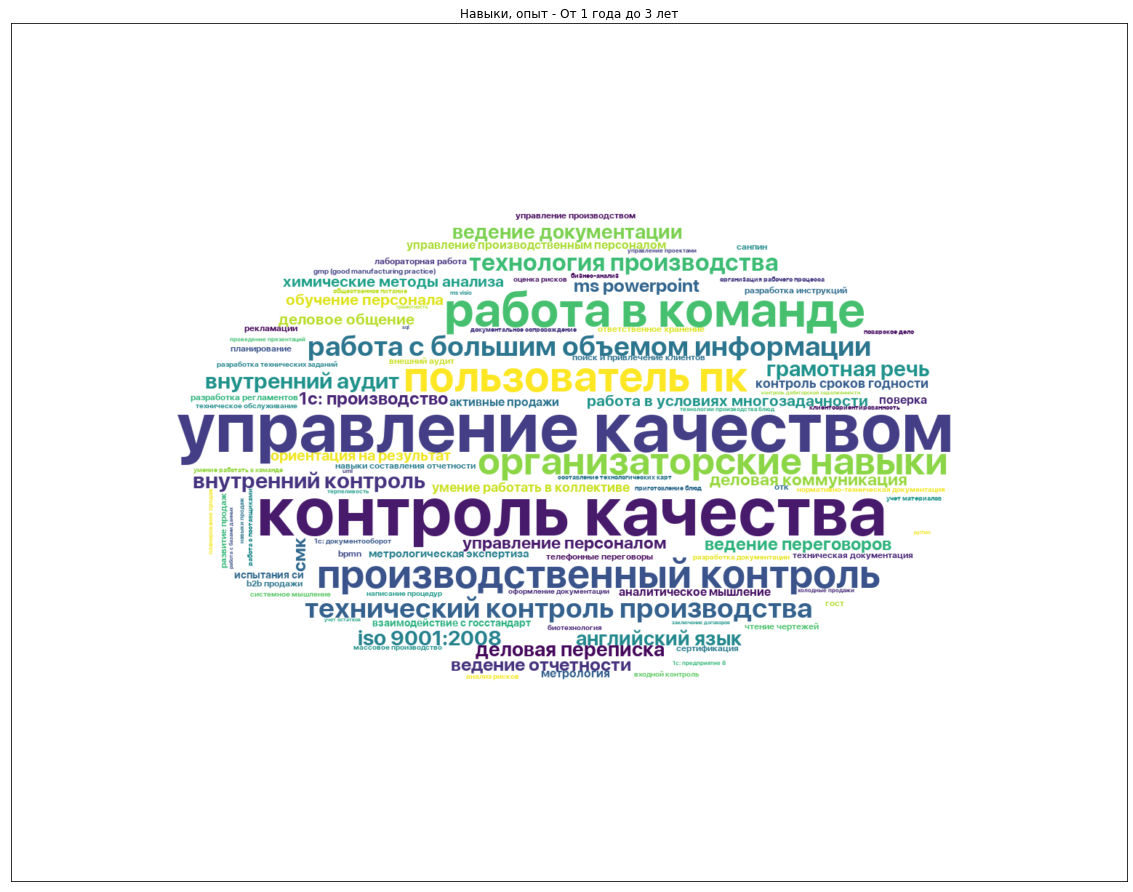

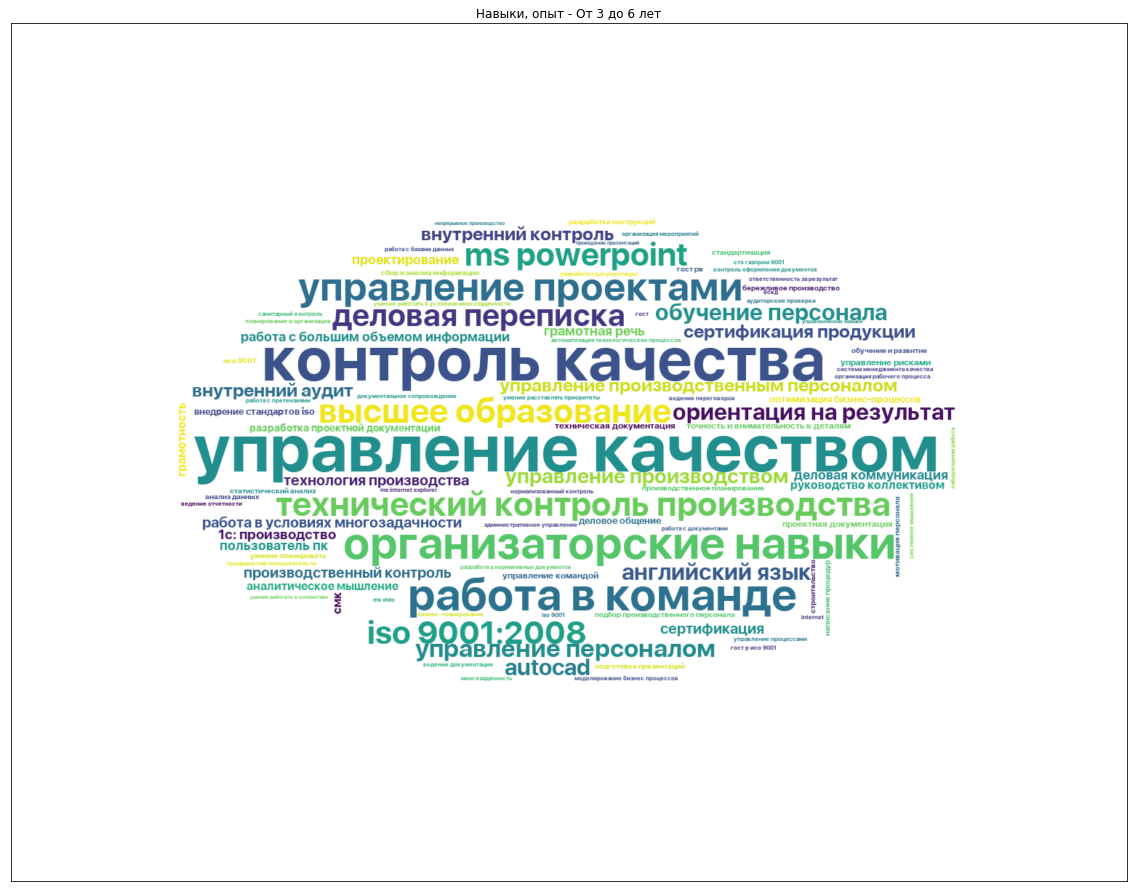

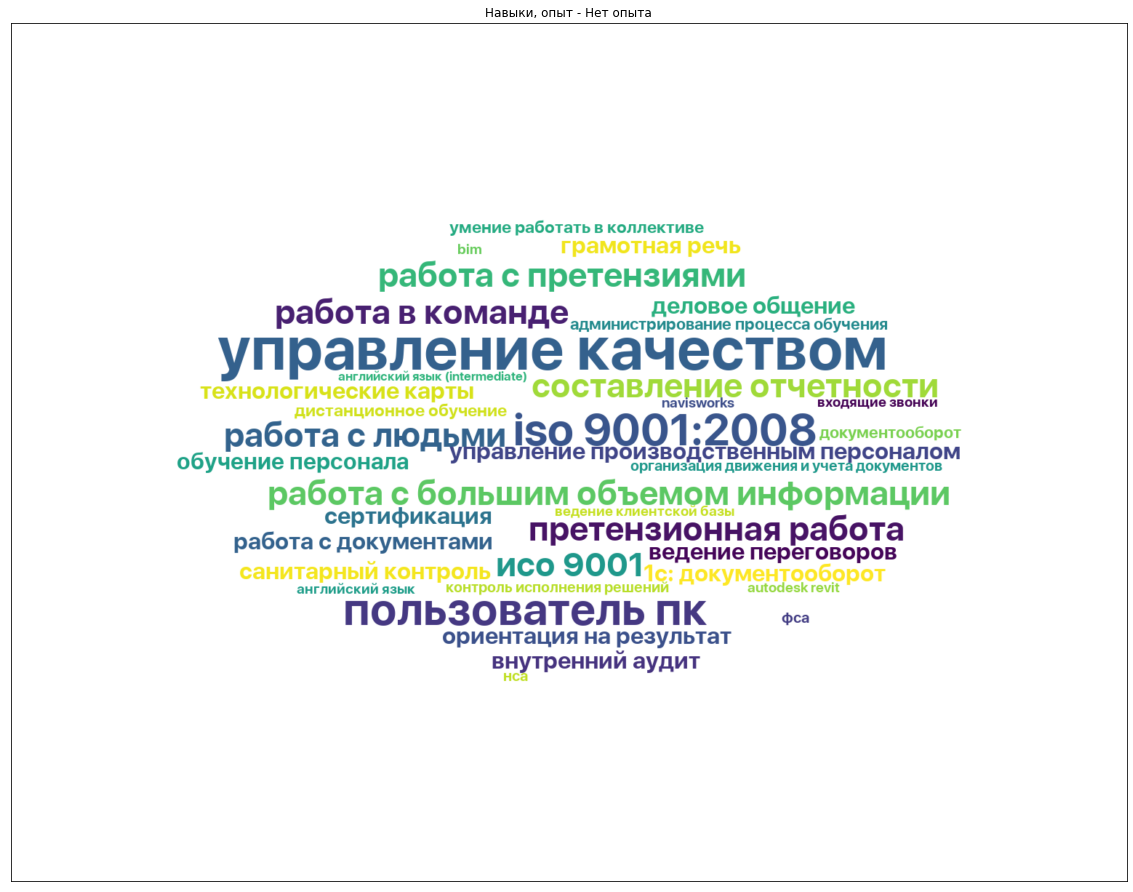

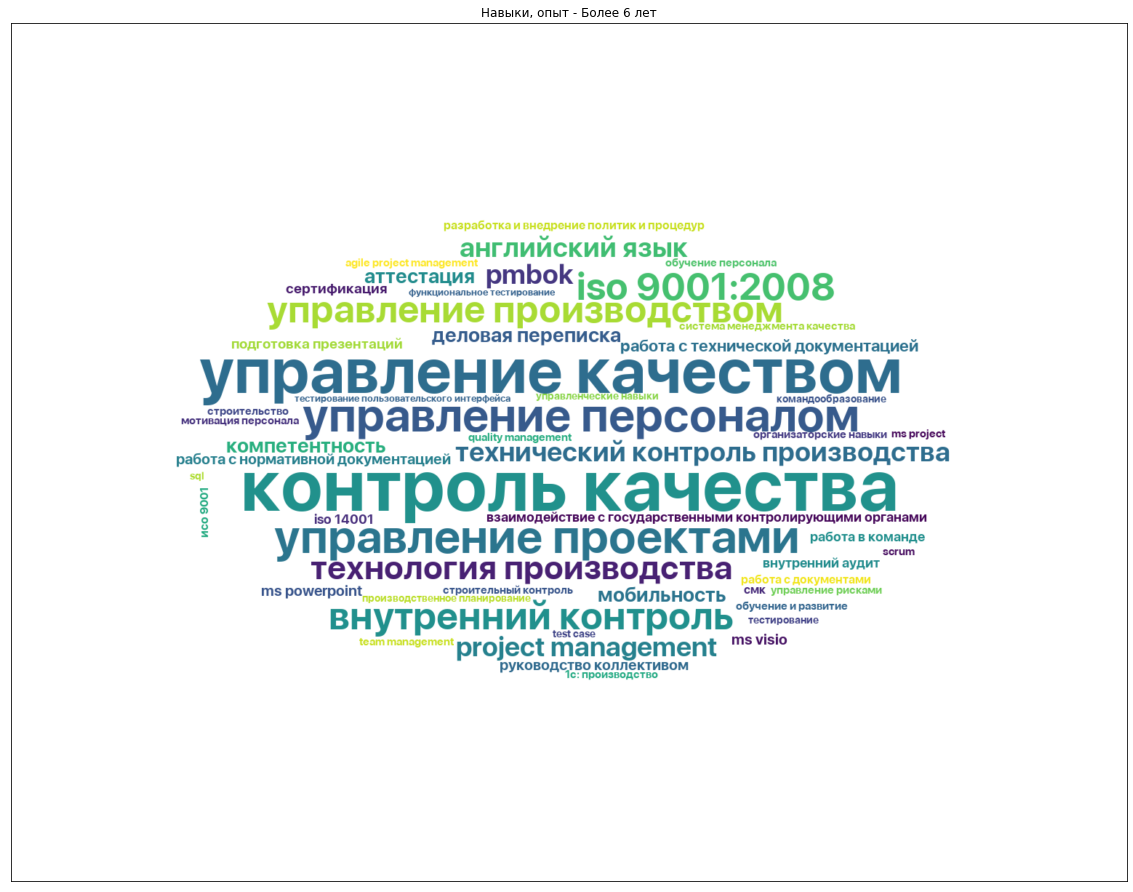

In [27]:
experience = list(df['experience'].unique())
#font_path = 'C:/Users/Виктория/Desktop/КАТЯ ФЕДОСОВА/Консалтинг/hh/sfns-display-bold.ttf'
#mask = np.array(Image.open('C:/Users/Виктория/Desktop/КАТЯ ФЕДОСОВА/Консалтинг/hh/oval.jpg'))
font_path = 'D:/Катя/Работа ЦКО/шрифты/кириллица/sfns-display-bold.ttf'
mask = np.array(Image.open('D:/Катя/Работа ЦКО/шрифты/oval.jpg'))
for ex in experience:
    try:
        skills = [review.lower() for review in df[df['experience'] == ex].skills for review in review]
        skills = dict(Counter(skills))
        plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
        wc = WordCloud(mask=mask, max_words = 100, background_color='white', font_path=font_path, collocations=False, width=mask.shape[1], height=mask.shape[0]).generate_from_frequencies(skills)
        plt.title(f'Навыки, опыт - {ex}')
        plt.xticks([])
        plt.yticks([])
        plt.imshow(wc , interpolation = 'bilinear')
        plt.savefig(f'{vacancy_name}/{todays_date}_wordcloud_skills_experience_{ex}.png')
    except:
        pass    


In [28]:
#plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
#wc = WordCloud(width = 1600 , height = 800 , max_words = 100).generate(skills)
#plt.imshow(wc , interpolation = 'bilinear')